In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import time 
import scipy
import investpy
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Import data

In [30]:
ft = yf.download("CL=F RB=F HO=F NG=F ESSO.BK BCP.BK",start="2010-01-02",end="2020-08-31")
ft.fillna(method='bfill', inplace=True)
ft = ft.dropna()
ft = ft['Adj Close']
ft.head()

[*********************100%***********************]  6 of 6 completed


,BCP.BK,CL=F,ESSO.BK,HO=F,NG=F,RB=F
Date,,,,,,
2010-01-04,8.627183,81.510002,5.389438,2.1905,5.884,2.1044
2010-01-05,8.685084,81.769997,5.389438,2.1941,5.637,2.1250
2010-01-06,8.627183,83.180000,5.389438,2.2032,6.009,2.1366
2010-01-07,8.627183,82.660004,5.431874,2.1836,5.806,2.1349
2010-01-08,8.569283,82.750000,5.431874,2.2003,5.749,2.1553


In [31]:
st = yf.download("PTTEP.BK TVO.BK SCC.BK BTS.BK TNPC.BK",start="2010-01-02",end="2020-08-31")
st.fillna(method='bfill', inplace=True)
st = st.dropna()
st = st['Adj Close']
st.head()

[*********************100%***********************]  5 of 5 completed


,BTS.BK,PTTEP.BK,SCC.BK,TNPC.BK,TVO.BK
Date,,,,,
2010-01-04,2.294183,91.686096,159.190170,0.380774,9.123015
2010-01-05,2.294183,92.628090,159.190170,0.380774,9.123015
2010-01-06,2.255942,93.570053,157.140518,0.380774,9.173982
2010-01-07,2.255942,92.628090,154.407623,0.380774,9.224945
2010-01-08,2.255942,93.256287,155.090866,0.380774,9.275917


In [32]:
PTT = ft.join(st['PTTEP.BK'])
PTT = PTT.dropna()
PTT

,BCP.BK,CL=F,ESSO.BK,HO=F,NG=F,RB=F,PTTEP.BK
Date,,,,,,,
2010-01-04,8.627183,81.510002,5.389438,2.1905,5.884,2.1044,91.686096
2010-01-05,8.685084,81.769997,5.389438,2.1941,5.637,2.1250,92.628090
2010-01-06,8.627183,83.180000,5.389438,2.2032,6.009,2.1366,93.570053
2010-01-07,8.627183,82.660004,5.431874,2.1836,5.806,2.1349,92.628090
2010-01-08,8.569283,82.750000,5.431874,2.2003,5.749,2.1553,93.256287
...,...,...,...,...,...,...,...
2020-08-24,17.600000,42.619999,6.700000,1.2476,2.513,1.3671,90.500000
2020-08-25,17.299999,43.349998,6.900000,1.2601,2.489,1.3959,91.250000
2020-08-26,17.500000,43.389999,6.850000,1.2447,2.461,1.3606,91.250000


In [33]:
# df = pd.read_csv('BZ=F.csv')
# df = df.rename(columns={'วันเดือนปี' : 'Date','ล่าสุด' : 'BZ=F'})
# df = df[['BZ=F']]

# PTT = PTT.merge(df)
# PTT

# Visualize the Time Series

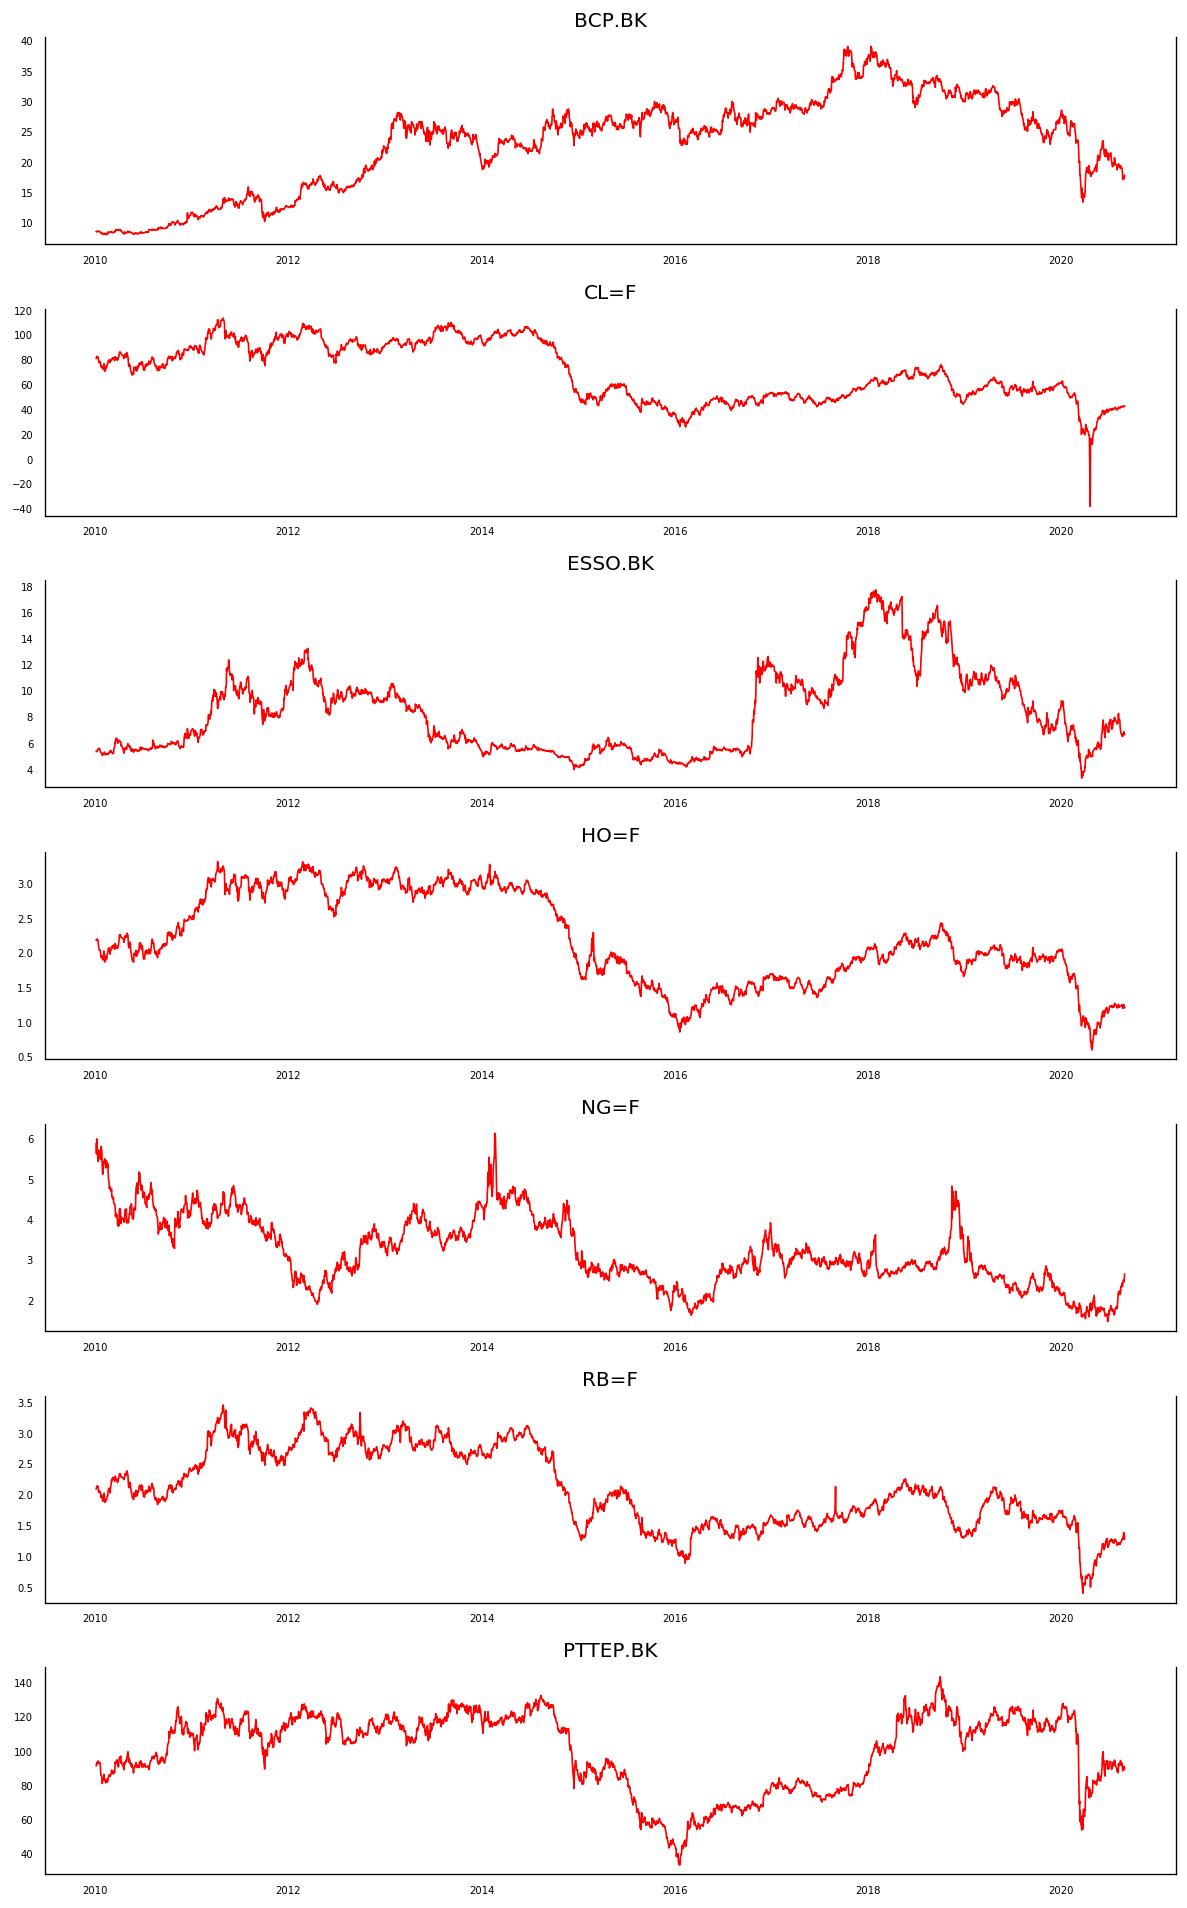

In [34]:
fig, axes = plt.subplots(nrows=len(PTT.columns), ncols=1, dpi=120, figsize=(10,16))
for i, ax in enumerate(axes.flatten()):
    data = PTT[PTT.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(PTT.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Correlation

In [35]:
PTT.corr().loc[['PTTEP.BK']]

,BCP.BK,CL=F,ESSO.BK,HO=F,NG=F,RB=F,PTTEP.BK
PTTEP.BK,-0.142434,0.726802,0.315066,0.758553,0.347232,0.685993,1.0


# Testing Causation using Granger’s Causality Test

In [36]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=24
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    PTT = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in PTT.columns:
        for r in PTT.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            PTT.loc[r, c] = min_p_value
    PTT.columns = [var + '_x' for var in variables]
    PTT.index = [var + '_y' for var in variables]
    return PTT

grangers_causation_matrix(PTT, variables = PTT.columns).loc[['PTTEP.BK_y']]   

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, bu

,BCP.BK_x,CL=F_x,ESSO.BK_x,HO=F_x,NG=F_x,RB=F_x,PTTEP.BK_x
PTTEP.BK_y,0.0136,0.0,0.0736,0.0,0.1572,0.0,1.0


# Cointegration Test

In [37]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(PTT, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(PTT,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(PTT.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(PTT)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
BCP.BK ::  105.08    > 111.7797  =>   False
CL=F   ::  67.68     > 83.9383   =>   False
ESSO.BK ::  39.06     > 60.0627   =>   False
HO=F   ::  22.87     > 40.1749   =>   False
NG=F   ::  13.86     > 24.2761   =>   False
RB=F   ::  5.55      > 12.3212   =>   False
PTTEP.BK ::  0.69      > 4.1296    =>   False


# Split the Series into Training and Testing Data

In [38]:
nobs = 7
ft_train, ft_test = PTT[0:-nobs], PTT[-nobs:]

# Check size
print(ft_train.shape)  
print(ft_test.shape)  
ft_train

(2596, 7)
(7, 7)


,BCP.BK,CL=F,ESSO.BK,HO=F,NG=F,RB=F,PTTEP.BK
Date,,,,,,,
2010-01-04,8.627183,81.510002,5.389438,2.1905,5.884,2.1044,91.686096
2010-01-05,8.685084,81.769997,5.389438,2.1941,5.637,2.1250,92.628090
2010-01-06,8.627183,83.180000,5.389438,2.2032,6.009,2.1366,93.570053
2010-01-07,8.627183,82.660004,5.431874,2.1836,5.806,2.1349,92.628090
2010-01-08,8.569283,82.750000,5.431874,2.2003,5.749,2.1553,93.256287
...,...,...,...,...,...,...,...
2020-08-13,19.500000,42.240002,6.950000,1.2381,2.182,1.2348,94.750000
2020-08-14,19.100000,42.009998,6.800000,1.2367,2.356,1.2446,92.000000
2020-08-17,19.100000,42.889999,6.700000,1.2391,2.339,1.2700,92.000000


# Check for Stationarity and Make the Time Series Stationary

In [39]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [40]:
# ADF Test on each column
for name, column in ft_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BCP.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9706
 No. Lags Chosen       = 9
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.2996. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CL=F" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4856
 No. Lags Chosen       = 7
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.5406. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ESSO.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has un

In [41]:
# 1st difference
ft_differenced = ft_train.diff().dropna()

In [42]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in ft_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BCP.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.6668
 No. Lags Chosen       = 8
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CL=F" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -18.7564
 No. Lags Chosen       = 6
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ESSO.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

In [43]:
# # Second Differencing
# ft_differenced = ft_differenced.diff().dropna()

In [44]:
# # ADF Test on each column of 2nd Differences Dataframe
# for name, column in ft_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

# Select the Order (P) of VAR model

In [45]:
model = VAR(ft_differenced)
for i in list(range(1,24)):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  -20.851350689963798
BIC :  -20.724822719095226
FPE :  8.797788445302101e-10
HQIC:  -20.805501142283184 

Lag Order = 2
AIC :  -20.90136182242721
BIC :  -20.664045998099574
FPE :  8.368628490476035e-10
HQIC:  -20.815364739205364 

Lag Order = 3
AIC :  -20.89423900370019
BIC :  -20.5460644285263
FPE :  8.428465945325852e-10
HQIC:  -20.768067118548007 

Lag Order = 4
AIC :  -20.890320502058714
BIC :  -20.431216205009655
FPE :  8.461588920959965e-10
HQIC:  -20.723946519439426 

Lag Order = 5
AIC :  -20.881885003443436
BIC :  -20.31177993974352
FPE :  8.533319654213137e-10
HQIC:  -20.675281598630264 

Lag Order = 6
AIC :  -20.87817705220816
BIC :  -20.197000103229705
FPE :  8.565095328157992e-10
HQIC:  -20.63131687124189 

Lag Order = 7
AIC :  -20.85738378303931
BIC :  -20.06506375619724
FPE :  8.745163524146582e-10
HQIC:  -20.5702394426858 

Lag Order = 8
AIC :  -20.85008428713755
BIC :  -19.94654991578377
FPE :  8.809375689684714e-10
HQIC:  -20.52262837484515 

Lag Or

In [46]:
#Lag Order = 3
x = model.select_order(maxlags=4)
x.summary()

,AIC,BIC,FPE,HQIC
0,-20.64,-20.62,1.090e-09,-20.63
1,-20.85,-20.72*,8.800e-10,-20.81
2,-20.90*,-20.66,8.397e-10*,-20.81*
3,-20.89,-20.54,8.448e-10,-20.77
4,-20.89,-20.43,8.462e-10,-20.72


# Train the VAR Model of Selected Order(p)

In [47]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 19, Nov, 2020
Time:                     23:36:03
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -20.5461
Nobs:                     2592.00    HQIC:                  -20.7681
Log likelihood:           1487.71    FPE:                8.42847e-10
AIC:                     -20.8942    Det(Omega_mle):     7.94428e-10
--------------------------------------------------------------------
Results for equation BCP.BK
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.005091         0.008407            0.606           0.545
L1.BCP.BK          -0.085795         0.022104           -3.881           0.000
L1.CL=F             0.014871         0.005442            2.733     

# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [48]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(PTT.columns, out):
    print( col,':', round(val, 2))

BCP.BK : 2.01
CL=F : 2.02
ESSO.BK : 2.0
HO=F : 2.0
NG=F : 2.0
RB=F : 2.0
PTTEP.BK : 2.0


# Forecast VAR model using statsmodels

In [49]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = ft_differenced.values[-lag_order:]
forecast_input

3


array([[ 0.        ,  0.88000107, -0.10000038,  0.00239992, -0.01699996,
         0.02539992,  0.        ],
       [ 0.        ,  0.        ,  0.05000019,  0.02130008,  0.07800007,
         0.01300001,  1.25      ],
       [-0.5       ,  0.04000092, -0.19999981, -0.00940001,  0.00900006,
         0.00750005, -1.25      ]])

In [50]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
ft_forecast = pd.DataFrame(fc, index=PTT.index[-nobs:], columns=PTT.columns + '_1d')
ft_forecast


,BCP.BK_1d,CL=F_1d,ESSO.BK_1d,HO=F_1d,NG=F_1d,RB=F_1d,PTTEP.BK_1d
Date,,,,,,,
2020-08-20,0.050457,-0.049497,0.008592,0.001964,0.001869,0.000148,0.117094
2020-08-21,-0.022534,-0.026667,-0.014935,-0.000188,-0.000895,-0.001652,-0.116961
2020-08-24,0.028650,-0.015465,0.008397,-0.000415,-0.003504,-0.001617,-0.001453
2020-08-25,-0.001688,-0.025551,-0.000687,-0.000629,-0.000874,-0.000437,-0.009036
2020-08-26,0.005185,-0.008870,0.000789,-0.000334,-0.001421,-0.000191,0.002378
2020-08-27,0.002138,-0.020830,-0.000138,-0.000396,-0.001332,-0.000263,-0.001092
2020-08-28,0.004254,-0.012502,0.000470,-0.000338,-0.001325,-0.000340,-0.000555


# Invert the transformation to get the real forecast

In [51]:
def invert_transformation(ft_train, ft_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    ft_fc = ft_forecast.copy()
    columns = ft_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            ft_fc[str(col)+'_1d'] = (ft_train[col].iloc[-1]-ft_train[col].iloc[-2]) + ft_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        ft_fc[str(col)+'_forecast'] = ft_train[col].iloc[-1] + ft_fc[str(col)+'_1d'].cumsum()
    return ft_fc

In [52]:
ft_results = invert_transformation(ft_train, ft_forecast, second_diff=False)        
ft_results.loc[:, ["CL=F_forecast" ,"HO=F_forecast", "NG=F_forecast", "RB=F_forecast" ,"PTTEP.BK_forecast" ]]

,CL=F_forecast,HO=F_forecast,NG=F_forecast,RB=F_forecast,PTTEP.BK_forecast
Date,,,,,
2020-08-20,42.880503,1.252964,2.427869,1.290648,92.117094
2020-08-21,42.853836,1.252776,2.426974,1.288996,92.000133
2020-08-24,42.838371,1.252361,2.423470,1.287379,91.998680
2020-08-25,42.812819,1.251732,2.422596,1.286942,91.989644
2020-08-26,42.803950,1.251398,2.421175,1.286752,91.992022
2020-08-27,42.783120,1.251002,2.419842,1.286489,91.990930
2020-08-28,42.770618,1.250664,2.418517,1.286149,91.990375


# Plot of Forecast vs Actuals

Forecast Accuracy of: PTTEP
mae (Mean Absolute Error) :  1.6541
rmse (Root Mean Square Error) :  1.8951
mape (Mean absolute percentage error) :  1.8412


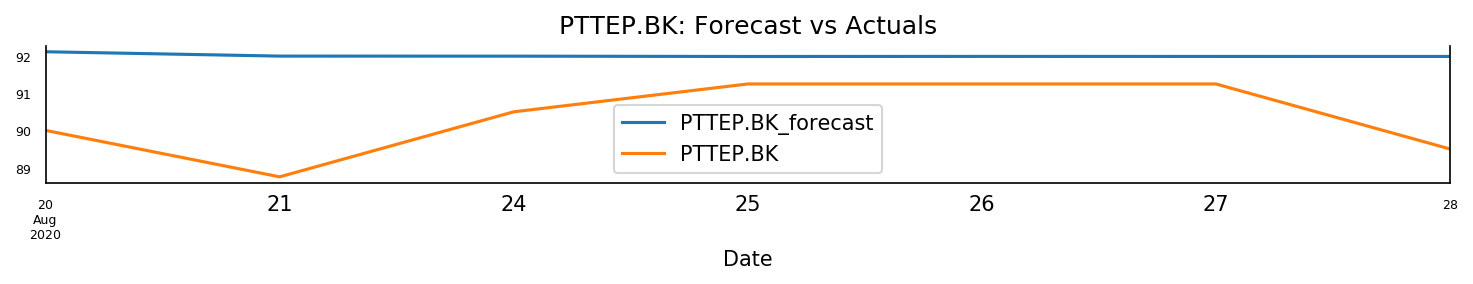

In [53]:


fig, axes = plt.subplots(nrows=1, ncols=1, dpi=150, figsize=(10,2))
ft_results['PTTEP.BK'+'_forecast'].plot(legend=True).autoscale(axis='x',tight=True)
ft_test['PTTEP.BK'].plot(legend=True );
axes.set_title('PTTEP.BK' + ": Forecast vs Actuals")
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
#  
#     n = train.shape[0]
#     d = np.abs(  np.diff( train) ).sum()/(n-1)
    
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     mase = np.mean(np.abs(actual - forecast ))/d
    
#     me = np.mean(forecast - actual)             # ME
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mae (Mean Absolute Error)': mae, 
            'rmse (Root Mean Square Error)':rmse,
            'mape (Mean absolute percentage error)':mape*100})

print('Forecast Accuracy of: PTTEP')
accuracy_prod = forecast_accuracy(ft_results['PTTEP.BK_forecast'].values, ft_test['PTTEP.BK'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
plt.tight_layout();



#  Plot of Forecast vs Actuals ( Forecast 1 year )

In [55]:
start = 0
end = 2441
nobs = 7
max_row = len(PTT) - end

forecast_results = pd.DataFrame()
forecast_test = PTT[end:]


while max_row > 0 :
    if(max_row < nobs):
        ft_train, ft_test = PTT[start:end] , PTT[end:end+max_row]
    else :
        ft_train, ft_test = PTT[start:end] , PTT[end:end+nobs]

    ft_differenced = ft_train.diff().dropna()

    model = VAR(ft_differenced)

    model_fitted = model.fit(2)
    model_fitted.summary()

    lag_order = model_fitted.k_ar

    # Input data for forecasting
    forecast_input = ft_differenced.values[-lag_order:]


    # Forecast
    if(max_row < nobs):
        fc = model_fitted.forecast(y=forecast_input, steps=max_row)
        ft_forecast = pd.DataFrame(fc, index=PTT.index[end:end+max_row], columns=PTT.columns + '_1d')
    else:
        fc = model_fitted.forecast(y=forecast_input, steps=nobs)
        ft_forecast = pd.DataFrame(fc, index=PTT.index[end:end+nobs], columns=PTT.columns + '_1d')


    ft_results = invert_transformation(ft_train, ft_forecast, second_diff=False)        
    ft_results.loc[:, ["PTTEP.BK_forecast" ]]
    
    forecast_results = forecast_results.append(ft_results)  
    
    if(max_row < nobs):
        start += max_row
        end += max_row
        max_row -= max_row
        break    
        
    start += nobs
    end += nobs
    max_row -= nobs
    



c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-pa

In [56]:
month = 8
day = 28
New_forecast = pd.DataFrame()
for i in range(0,7):
    day += 1
    if(day > 31):
        month +=1
        day=1
    date = '2020'+'-'+str(month)+'-'+str(day)
    new_date = pd.DataFrame(index = [date])
    New_forecast = New_forecast.append(new_date)
    
ft_train = PTT[start:end] 

ft_differenced = ft_train.diff().dropna()

model = VAR(ft_differenced)

model_fitted = model.fit(2)
model_fitted.summary()

lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = ft_differenced.values[-lag_order:]


# Forecast
# if(max_row < nobs):
#     fc = model_fitted.forecast(y=forecast_input, steps=max_row)
#     ft_forecast = pd.DataFrame(fc, index=PTT.index[end:end+max_row], columns=PTT.columns + '_1d')
# else:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
ft_forecast_n = pd.DataFrame(fc, index=New_forecast.index[0:7], columns=PTT.columns + '_1d')


ft_results_n = invert_transformation(ft_train, ft_forecast_n, second_diff=False)        
ft_results_n.loc[:, ["PTTEP.BK_forecast" ]]

forecast_results_n = ft_results_n
forecast_results_n.index.names = ['Date']

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [57]:
forecast_results.loc[:, ["PTTEP.BK_forecast" ]]

,PTTEP.BK_forecast
Date,
2020-01-02,119.072762
2020-01-03,119.103377
2020-01-06,119.111611
2020-01-07,119.124682
2020-01-08,119.134994
...,...
2020-08-24,93.413906
2020-08-25,93.412608
2020-08-26,93.413002


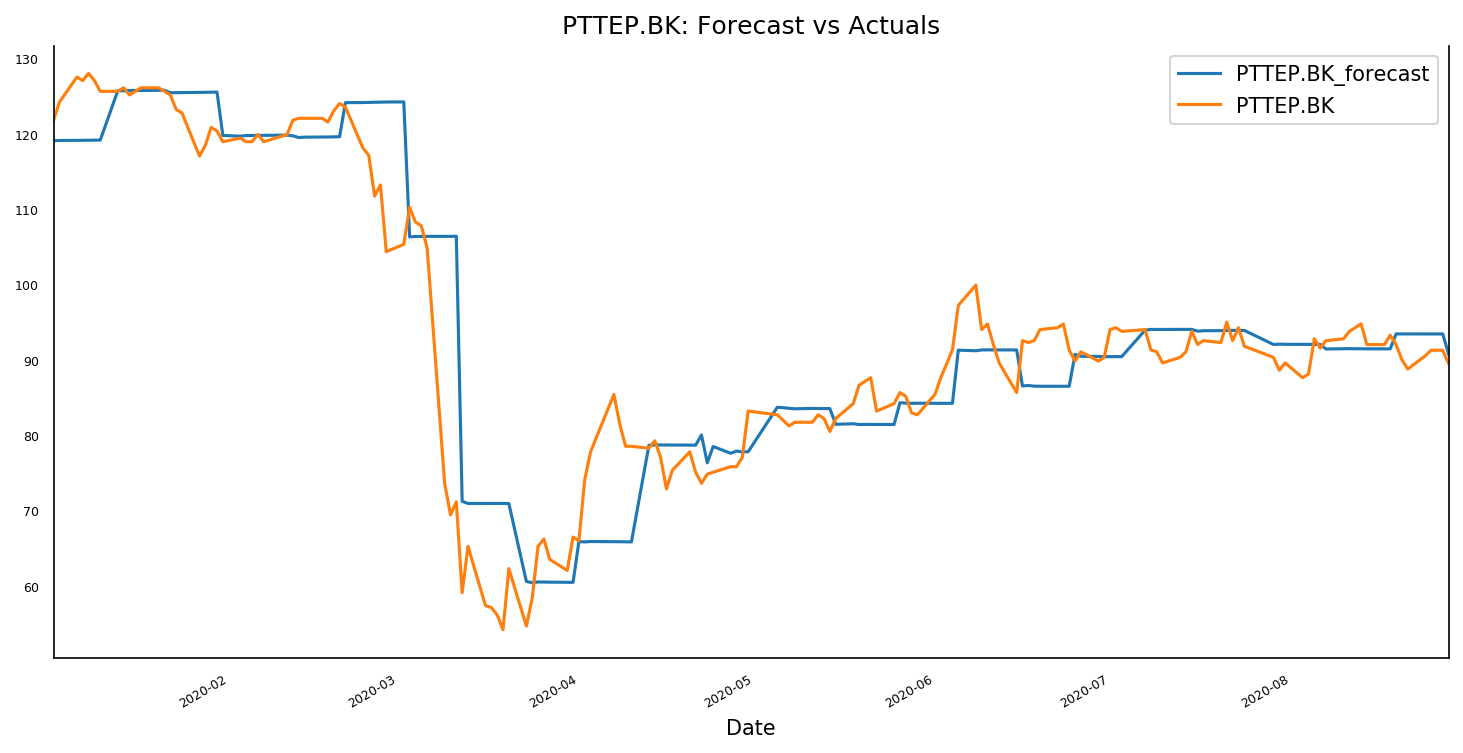

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=150, figsize=(12,6))
forecast_results['PTTEP.BK'+'_forecast'].plot(legend=True).autoscale(axis='x',tight=True)
forecast_test['PTTEP.BK'].plot(legend=True );
axes.set_title('PTTEP.BK' + ": Forecast vs Actuals")
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)

In [59]:
forecast_results_n.loc[:, ["PTTEP.BK_forecast" ]]

,PTTEP.BK_forecast
Date,
2020-8-29,89.620574
2020-8-30,89.762869
2020-8-31,89.757017
2020-9-1,89.746044
2020-9-2,89.741836
2020-9-3,89.740343
2020-9-4,89.738378


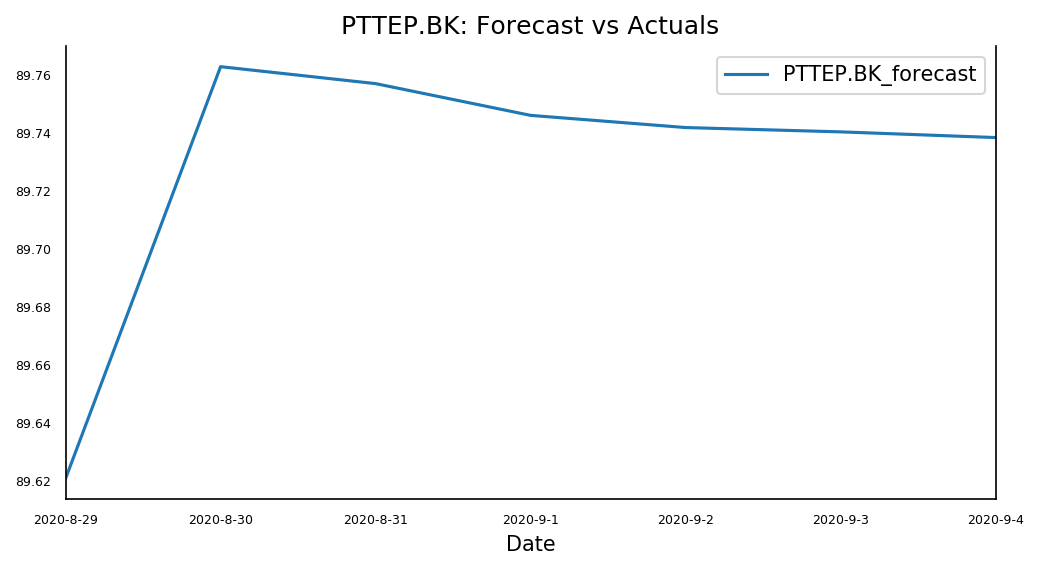

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=150, figsize=(8,4))
forecast_results_n['PTTEP.BK'+'_forecast'].plot(legend=True).autoscale(axis='x',tight=True)
axes.set_title('PTTEP.BK' + ": Forecast vs Actuals")
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)

# Evaluate the Forecasts

In [61]:
print('Forecast Accuracy of: PTTEP\n')
accuracy_prod = forecast_accuracy(forecast_results['PTTEP.BK_forecast'].values, forecast_test['PTTEP.BK'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
plt.tight_layout();

Forecast Accuracy of: PTTEP

mae (Mean Absolute Error) :  4.5875
rmse (Root Mean Square Error) :  7.4331
mape (Mean absolute percentage error) :  5.5218


<Figure size 432x288 with 0 Axes>